### Emotion Detection

#### libraries

In [2]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.13.0


#### Dataset

In [3]:
images = glob("/kaggle/input/fer2013/train/**/**")

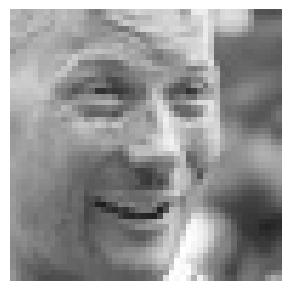

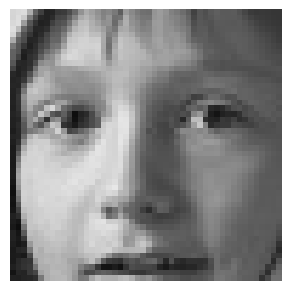

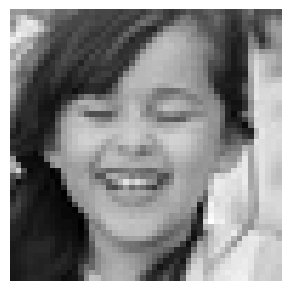

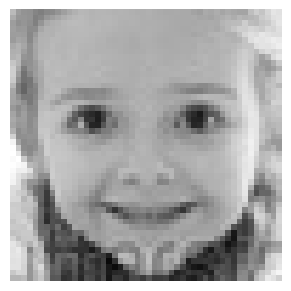

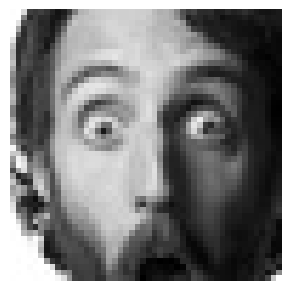

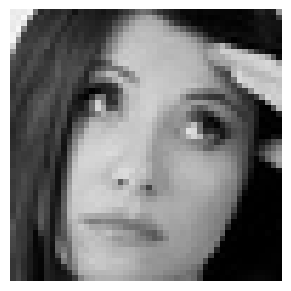

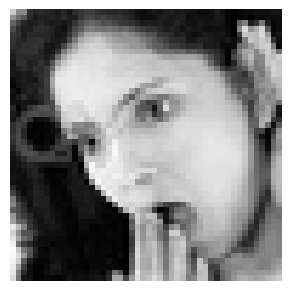

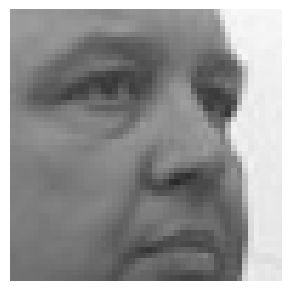

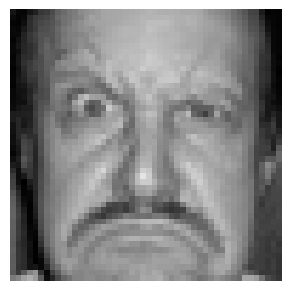

In [5]:
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize = (12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image))
    plt.axis('off')

#### Data preparation for training

In [7]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator(horizontal_flip = True)
train_generator = datagen_train.flow_from_directory("/kaggle/input/fer2013/train/",
                                                   target_size = (img_size,img_size),
                                                    color_mode ="grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)
datagen_validation = ImageDataGenerator(horizontal_flip = True)
validation_generator = datagen_train.flow_from_directory("/kaggle/input/fer2013/test/",
                                                   target_size = (img_size,img_size),
                                                    color_mode ="grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [8]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size,padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)
    return x

In [9]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    return x

In [10]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,64,(3,3))
    conv_2 = Convolution(conv_1,128,(5,5))
    conv_3 = Convolution(conv_2,512,(3,3))
    conv_4 = Convolution(conv_3,512,(3,3))
    
    flatten = Flatten()(conv_4)
    dense_1 = Dense_f(flatten,256)
    dense_2 = Dense_f(dense_1,512)
    output = Dense(7,activation = 'softmax')(dense_2)
    
    model = Model(inputs = [inputs], outputs = [output])
    
    opt = Adam(lr = 0.0005)
    model.compile(loss = ['categorical_crossentropy'], optimizer = opt,
                          metrics = ['accuracy'])
    return model          

In [11]:
model = model_fer((48,48,1))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0     

#### Initializing the model

In [12]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint('model_weights.h5',monitor = 'val_accuracy', 
                              save_weights_only = True, mode = 'max', 
                              verbose = -1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience = 2, min_lr = 0.00001)
callbacks = [checkpoint,reduce_lr]

#### Training the model

In [13]:
history = model.fit(
    x = train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks = callbacks)

Epoch 1/15


2023-12-13 18:00:47.130076: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


448/448 [==============================] - 182s 378ms/step - loss: 1.7447 - accuracy: 0.3271 - val_loss: 1.5945 - val_accuracy: 0.3951 - lr: 0.0010
Epoch 2/15
448/448 [==============================] - 37s 83ms/step - loss: 1.3811 - accuracy: 0.4705 - val_loss: 1.3367 - val_accuracy: 0.4883 - lr: 0.0010
Epoch 3/15
448/448 [==============================] - 36s 79ms/step - loss: 1.2615 - accuracy: 0.5188 - val_loss: 1.3989 - val_accuracy: 0.4718 - lr: 0.0010
Epoch 4/15
448/448 [==============================] - 39s 87ms/step - loss: 1.1890 - accuracy: 0.5463 - val_loss: 1.3091 - val_accuracy: 0.5018 - lr: 0.0010
Epoch 5/15
448/448 [==============================] - 36s 81ms/step - loss: 1.1467 - accuracy: 0.5649 - val_loss: 1.2433 - val_accuracy: 0.5205 - lr: 0.0010
Epoch 6/15
448/448 [==============================] - 36s 80ms/step - loss: 1.1072 - accuracy: 0.5815 - val_loss: 1.1822 - val_accuracy: 0.5629 - lr: 0.0010
Epoch 7/15
448/448 [==============================] - 38s 85ms/step

#### Model Evaluation

In [14]:
model.evaluate(validation_generator)

113/113 [==============================] - 7s 64ms/step - loss: 0.9462 - accuracy: 0.6548


[0.9462340474128723, 0.6547784805297852]

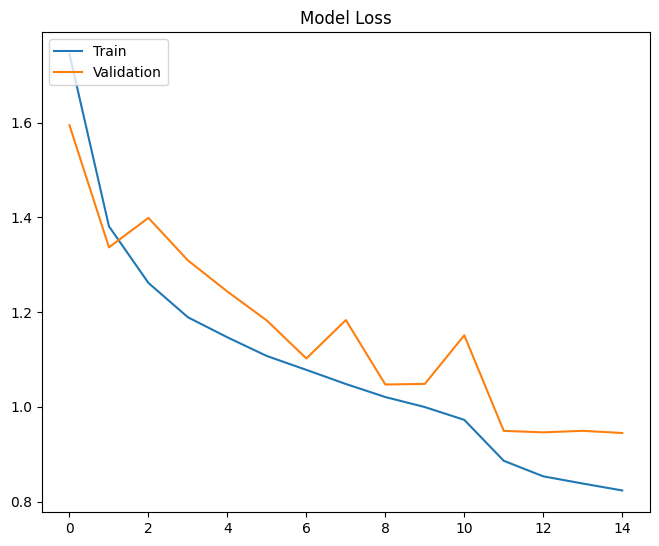

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc='upper left')
plt.subplots_adjust(top = 1.0,bottom=0.0,right=0.95,left=0.0,hspace = 0.25, wspace = 0.35)

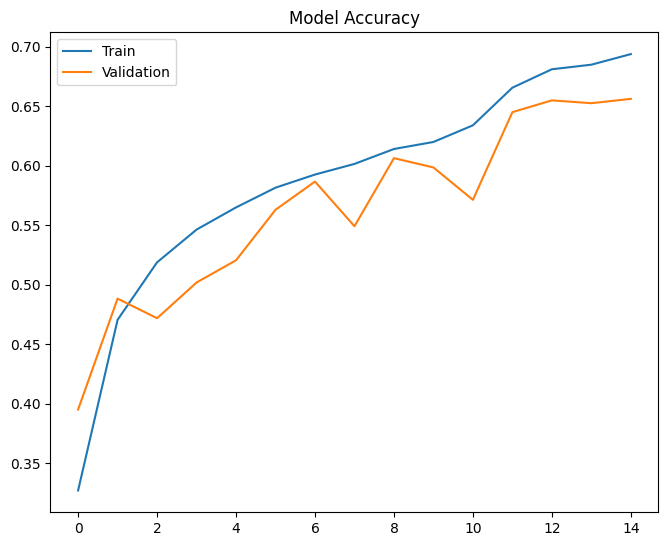

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc='upper left')
plt.subplots_adjust(top = 1.0,bottom=0.0,right=0.95,left=0.0,hspace = 0.25, wspace = 0.35)

#### Saving model

In [19]:
model_json = model.to_json()
with open('model_a.json','w') as json_file:
    json_file.write(model_json)